# 필요 라이브러리 호출

In [1]:
import os, tqdm, math, random, argparse

import numpy as np
import pandas as pd

from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp
from pytorch_msssim import MS_SSIM

import cv2
import random

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

#device는 학습 환경을 cpu로 할 것인지 아니면 gpu로 할것인지 에 대한 변수이다.
# torch.cuda.is_available()는 말 그대로 cuda(gpu)을 사용할 수 있으면 사용하겠다는 의미

cuda:0


# 빛번짐 최소화 인공지능 데이터 수집

Dacon : https://dacon.io/competitions/official/235746/data

DACON에서 가져온 같은장소에서 빛번짐이 존재하는 이미지 데이터 622개와 빛 번짐이 없는 이미지 데이터 622개로 이루어진 데이터셋을 제공해줘서 이 데이터셋을 다운로드. 

 모두 비정형 데이터 이며 이미지 크기는 3264*2448와 1632*1224 두가지의 PNG형식의 비정형 데이터임.

 개발 시 622개의 데이터셋을 학습용으로 562개 검증용으로 60개로 사용하였음.
-빛이 번져있는 사진을 인공지능에 넣었을 때 생성되는 빛이 줄이든 사진이 이미 준비해둔 빛이 안번져있는 사진과 시각 적으로 비교해서 얼마나 잘 줄어들었는지 확인하기위함.

 DACON에서 다운받는 데이터로만 진행했기 때문에 위의 과정을 거치고 같은 장소의 빛이 번져있는 사진과 안번져있는 사진을 구할 수 있으면 파일 형식과 사진 개수는 무관함.


# directory 확인

In [3]:
cd C:/Users/ChangHwan/Desktop/data

C:\Users\ChangHwan\Desktop\data


In [4]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: D8CF-C1D7

 C:\Users\ChangHwan\Desktop\data 디렉터리

2022-05-19  오후 04:52    <DIR>          .
2022-05-19  오후 04:52    <DIR>          ..
2022-05-19  오후 04:43                23 .jovianrc
2022-04-27  오후 04:03        26,648,315 efficientnet.pt
2022-05-19  오후 04:27    <DIR>          night_test
2022-05-19  오후 04:00    <DIR>          result
2021-06-25  오후 03:34               894 test.csv
2022-02-19  오후 12:18    <DIR>          test_input_img
2021-06-25  오후 03:34            31,750 train.csv
2022-02-19  오후 12:19    <DIR>          train_input_img
2022-02-19  오후 12:20    <DIR>          train_label_img
2022-05-19  오후 04:31    <DIR>          낮
2022-05-19  오후 04:23    <DIR>          밤
               4개 파일          26,680,982 바이트
               9개 디렉터리  20,352,176,128 바이트 남음


In [5]:
cd C:/Users/ChangHwan/Desktop/data/train_input_img

C:\Users\ChangHwan\Desktop\data\train_input_img


In [6]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: D8CF-C1D7

 C:\Users\ChangHwan\Desktop\data\train_input_img 디렉터리

2022-02-19  오후 12:19    <DIR>          .
2022-02-19  오후 12:19    <DIR>          ..
2021-06-24  오후 06:51         9,537,608 train_input_10000.png
2021-06-24  오후 06:51         9,793,349 train_input_10001.png
2021-06-24  오후 06:51         9,559,877 train_input_10002.png
2021-06-24  오후 06:51        10,058,353 train_input_10003.png
2021-06-24  오후 06:51         9,513,943 train_input_10004.png
2021-06-24  오후 06:51        10,143,577 train_input_10005.png
2021-06-24  오후 06:51         9,354,684 train_input_10006.png
2021-06-24  오후 06:51        10,989,486 train_input_10007.png
2021-06-24  오후 06:51        10,203,673 train_input_10008.png
2021-06-24  오후 06:51        10,171,885 train_input_10009.png
2021-06-24  오후 06:51        10,950,335 train_input_10010.png
2021-06-24  오후 06:52        10,809,451 train_input_10011.png
2021-06-24  오후 06:52        10,686,497 train_input_10012.png
2021-06-24  오후 06:52   

In [7]:
cd C:/Users/ChangHwan/Desktop


2021-06-24  오후 06:58         1,512,463 train_input_10406.png
2021-06-24  오후 06:59         1,386,607 train_input_10407.png
2021-06-24  오후 06:59         1,345,705 train_input_10408.png
2021-06-24  오후 06:59         1,367,909 train_input_10409.png
2021-06-24  오후 06:59         1,381,562 train_input_10410.png
2021-06-24  오후 06:59         1,749,246 train_input_10411.png
2021-06-24  오후 06:59         1,585,886 train_input_10412.png
2021-06-24  오후 06:59         1,755,206 train_input_10413.png
2021-06-24  오후 06:59         1,782,848 train_input_10414.png
2021-06-24  오후 06:59         1,712,337 train_input_10415.png
2021-06-24  오후 06:59         2,030,121 train_input_10416.png
2021-06-24  오후 06:59         1,750,521 train_input_10417.png
2021-06-24  오후 06:59         1,771,309 train_input_10418.png
2021-06-24  오후 06:59         1,667,576 train_input_10419.png
2021-06-24  오후 06:59         1,924,493 train_input_10420.png
2021-06-24  오후 06:59         1,810,508 train_input_10421.png
2021-06-24  오후 06:59   

In [8]:
train_csv = pd.read_csv('data/train.csv')
test_csv = pd.read_csv('data/test.csv')

In [9]:
train_csv.head()

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [10]:
test_csv.head()

,img_id,input_img,submission_name
0,20000,test_input_20000.png,test_20000.png
1,20001,test_input_20001.png,test_20001.png
2,20002,test_input_20002.png,test_20002.png
3,20003,test_input_20003.png,test_20003.png
4,20004,test_input_20004.png,test_20004.png


In [11]:
train_all_input_files = 'data/train_input_img/'+train_csv['input_img']
train_all_label_files = 'data/train_label_img/'+train_csv['label_img']
test_all_input_files = 'data/test_input_img/'+test_csv['input_img']

# 학습 데이터와 검증 데이터를 분리

In [12]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

In [13]:
vaild_input_files = train_all_input_files[:60].to_numpy()
vaild_label_files = train_all_label_files[:60].to_numpy()

In [14]:
train_input_files

array(['data/train_input_img/train_input_10060.png',
       'data/train_input_img/train_input_10061.png',
       'data/train_input_img/train_input_10062.png',
       'data/train_input_img/train_input_10063.png',
       'data/train_input_img/train_input_10064.png',
       'data/train_input_img/train_input_10065.png',
       'data/train_input_img/train_input_10066.png',
       'data/train_input_img/train_input_10067.png',
       'data/train_input_img/train_input_10068.png',
       'data/train_input_img/train_input_10069.png',
       'data/train_input_img/train_input_10070.png',
       'data/train_input_img/train_input_10071.png',
       'data/train_input_img/train_input_10072.png',
       'data/train_input_img/train_input_10073.png',
       'data/train_input_img/train_input_10074.png',
       'data/train_input_img/train_input_10075.png',
       'data/train_input_img/train_input_10076.png',
       'data/train_input_img/train_input_10077.png',
       'data/train_input_img/train_input_10078

In [15]:
vaild_input_files

array(['data/train_input_img/train_input_10000.png',
       'data/train_input_img/train_input_10001.png',
       'data/train_input_img/train_input_10002.png',
       'data/train_input_img/train_input_10003.png',
       'data/train_input_img/train_input_10004.png',
       'data/train_input_img/train_input_10005.png',
       'data/train_input_img/train_input_10006.png',
       'data/train_input_img/train_input_10007.png',
       'data/train_input_img/train_input_10008.png',
       'data/train_input_img/train_input_10009.png',
       'data/train_input_img/train_input_10010.png',
       'data/train_input_img/train_input_10011.png',
       'data/train_input_img/train_input_10012.png',
       'data/train_input_img/train_input_10013.png',
       'data/train_input_img/train_input_10014.png',
       'data/train_input_img/train_input_10015.png',
       'data/train_input_img/train_input_10016.png',
       'data/train_input_img/train_input_10017.png',
       'data/train_input_img/train_input_10018

# 빛번짐 데이터 열어서 확인

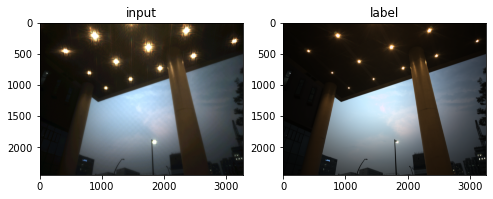

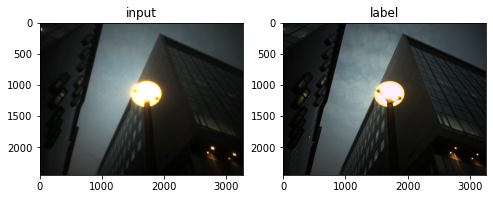

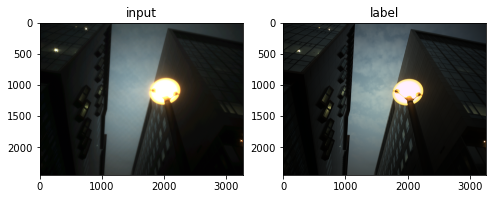

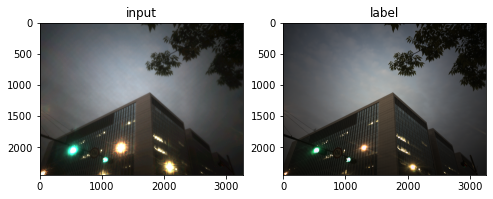

In [16]:
for i in range(4):
    origin_img = Image.open(f'data/train_input_img/train_input_{i+10060}.png')
    trans_img = Image.open(f'data/train_label_img/train_label_{i+10060}.png')
    fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
    ax[0].set_title('input')
    ax[0].imshow(origin_img)
    ax[1].set_title('label')
    ax[1].imshow(trans_img)
    plt.show()


# 빛번짐 최소화 데이터 처리

제공된 데이터의 크기(3264*2448 , 1632*1224)를 512*384의 크기로 축소시키는 과정을 거침

 데이터의 크기와 사용하는 인공지능 신경망을 gpu에 할당할 때 현재 colab에서 제공되는 최대 GPU는 15GB로 데이터 크기 그대로 사용했을 때 15GB로는 메모리가 부족한 현상이 발생해서 15GB에 최대한 맞는 크기로 이미지를 축소한 결과 512*384인걸 확인해서 이미지를 축소함

 만약 GPU MEMORY가 더 큰 GPU를 사용한다면 최대한 이미지의 크기를 보존하도록 하는 게 좋음
-이미지를 축소한다는 것은 이미지의 정보에 대해서 손실이 일어난다는 것을 의미하기 때문에


In [17]:
class CustomDataset(Dataset):
    def __init__(self, data, label,w,h ,is_train=True):
        self.data  = data
        self.label = label
        self.w = w
        self.h = h
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image, label):
        
        resizer = transforms.Resize(size=(self.h, self.w))
        image = resizer(image)
        label = resizer(label)

        image = TF.to_tensor(image)
        label = TF.to_tensor(label)
        return image, label
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        label_img  = Image.open(self.label[idx])
        
        origin_img, label_img = self.transform(origin_img, label_img)
        return origin_img, label_img
    
#def __init__는 생성자
#def __len__은 데이셋의 길이를 변환
#def __transform 에서 resize = 이미지 크기 재지정 , to_tensor = 이미지를 tensor형으로 변경
#def __getitem__은 이미지를 호출하고 transform함수를 적용 시킨 후 이미지를 호출

In [18]:
class testDataset(Dataset):
    def __init__(self, data,is_train=True):
        self.data  = data
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(384, 512))
        ])
        image = transform(image)
        
        return image
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        
        origin_img = self.transform(origin_img)
        return origin_img

In [19]:
train_dataset = CustomDataset(train_input_files, train_label_files,512,384)
vaild_dataset = CustomDataset(vaild_input_files, vaild_label_files,512,384)
test_dataset = testDataset(test_all_input_files)

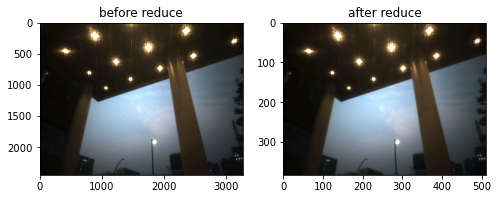

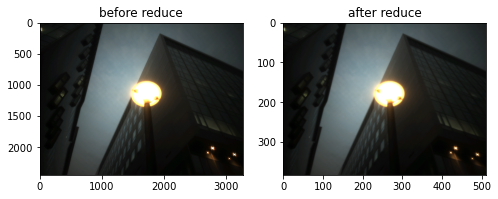

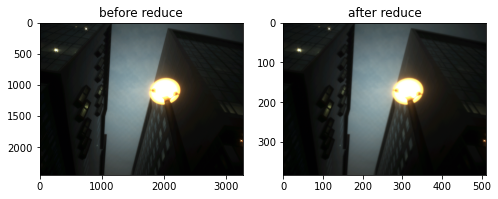

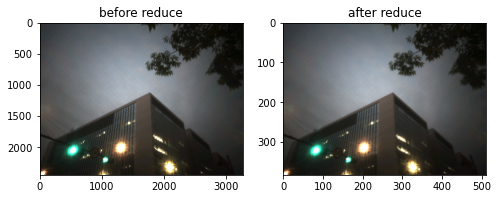

In [20]:
for i in range(4):
    origin_img = Image.open(f'data/train_input_img/train_input_{i+10060}.png')
    trans_img = train_dataset[i][0].numpy().transpose(1,2,0)
    fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
    ax[0].set_title('before reduce')
    ax[0].imshow(origin_img)
    ax[1].set_title('after reduce')
    ax[1].imshow(trans_img)
    plt.show()



In [21]:
train_loader = DataLoader(train_dataset , batch_size = 4, shuffle = True)
vaild_loader = DataLoader(vaild_dataset , batch_size = 4, shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = 1 , shuffle = True )

# 빛번짐 최소화 인공지능 모델 선정

 개발 시 사용할 인공지능 신경망으로는 CNN을 선정
다른 신경망들과 다르게 이미지 데이터를 처리 할 때 이미지의 단순한 특징 뿐만 아니라 패턴까지 알아 낼 수 있는 장점이 있기 때문임

 선정한 모델로는 Resnet , Mobilenet , Efficientnet임
-3가지 모델은 Resnet > Mobilenet > Efficinetnet으로
인공지능의 모델의 크기에 따른 성능을 비교하기 위해 위의 모델들을 선정하였음

 단 개발시에는 다른 모델을 사용해도 상관 없으나 CNN을 기초로 한 인공지능 모델을 선정하는 것을 추천
-단순히 특징만 추출해내는 DNN같은 신경망으로 해도 문제는 없으나 효과를 기대하기는 CNN에 비해서 기대 효과를 얻기 어렵기 때문임.


In [22]:
model = smp.UnetPlusPlus(encoder_name='efficientnet-b0',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')

'''
model = smp.UnetPlusPlus(encoder_name='efficientnet-b4',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
                

model = smp.UnetPlusPlus(encoder_name='mobilenet_v2',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
'''

"\nmodel = smp.UnetPlusPlus(encoder_name='efficientnet-b4',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n                \n\nmodel = smp.UnetPlusPlus(encoder_name='mobilenet_v2',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n"

In [23]:
model.to(device)
model
#model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet.pt'))

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
  

# 빛번짐 최소화 인공지능 모델 학습

빛번짐 최소화 인공지능 모델 학습

 선정한 모델 Resnet , Mobilenet , Efficientnet을 조원끼리 하나씩 맡아서 각자의 기기로 학습을 진행

 하나의 모델에 대해서 학습당 시간이 약 5분정도가 소요되고 최소한 성능을 내기 위해서는 100회 이상의 학습량이 필요했음. (ex)100회 학습 시 500분 소요)

 개발 환경 구축 , 데이터 수집 , 데이터 처리까지는 각자모두 같은 과정을 수행하고 각자 모델을 하나씩 맡아서 ex)고창환은 resnet, 김선영은 mobilenet 
300번의 횟수로 학습을 진행하였음

  -한 학기의 시간동안 빠르게 인공지능을 완성해야 하였기 때문에 위와 같은 방식을 선정하였음 


In [24]:
criterion = torch.nn.MSELoss().to(device) #예상 답과 실제 답의 차이를 줄이기 위한 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #가중치를 갱신해주는 함수
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 10, gamma=0.8)#학습에 사용 되는 가중치를 조절해주는 함수

In [ ]:
train_loss = []
vaild_loss=[]
for epoch in range(300):
    total_loss = 0
    model.train()
    
    for image , label in tqdm(train_loader,total=len(train_loader),leave = False):
        image = image.to(device)
        label = label.to(device)
        output = model(image.float())
        loss = torch.sqrt(criterion(output,label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    torch.save(model.state_dict(), 'data/efficientnet.pt')
    print("epoch :" , epoch+1 , "loss :" , total_loss/len(train_loader))
    
    scheduler.step()
    
    idx = 1
    
    model.eval()
    with torch.no_grad():
        for image , label in tqdm(vaild_loader,total=len(vaild_loader),leave = False):
            image = image.to(device)
            label = label.to(device)
            output = model(image.float())
            loss = torch.sqrt(criterion(output,label))
            
            total_loss += loss.item()
            

            target_path = 'data/result/' + str(epoch+1)+'/'
            if not os.path.exists(target_path):
                os.makedirs(target_path, exist_ok=True)

            grid = torchvision.utils.make_grid(tensor=torch.vstack([image,label,output]), nrow=image.shape[0])    # Saving results
            torchvision.utils.save_image(grid, target_path+str(idx)+'.png')
            idx +=1
        vaild_loss.append(total_loss/len(vaild_loader))
        print("val_epoch :" , epoch+1 , "val_loss :" , total_loss/len(vaild_loader))
    

#요약으로 dataset에서 문제(image)와 답지(label)을 호출 하고 model에 문제를 넣음(output = modle(image))
#output은 예상 답을 의미 하고 loss변수는 예상 답과 실제 답에 대한 차이를 줄여 나감
#zero_grad는 가중치를 초기화해주는 함수
#loss backward는 역전파 알고리즘에 대한 것으로 신경망 방향을 순방향으로 한번 역방향으로 한번 확인 후 비교를 하는 것
    

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

# 빛번짐 모델 검증

빛번짐 최소화 인공지능 모델 검증

 검증용(학습 때 사용하지 않음)으로 사용하기로 했던 60개의 빛이 번져있는 사진과 번져있지 않은 사진을 준비해서 번져있는 사진을 학습이 끝난 인공지능 모델에 넣고 그에 대한 결과를 번져있지 않은 사진과 비교해서 얼마나 빛이 잘 줄어들었는지 확인

 수치적으로 이를 검증할 수 없기 때문에 시각적으로 가장 빛을 잘 줄였다고 생각한 모델을 가장 빛을 최소화시킨 모델로 선정하기로 하고 이 모델을 최종적인 빛번짐 최소화 모델로 선정

 resnet mobilenet efficinetnet중 efficientnet이 가장 시각적으로 빛을 잘 줄였다고 생각해 efiicinetnet을 선정하였음


In [ ]:
results = [y for x in os.walk(f'data/result/1') for y in glob(os.path.join(x[0], '*.png'))]
width = 384
height = 512

In [ ]:
for idx, each_result in enumerate(results):
    if idx % 4 ==0:
        input  = np.array(Image.open(each_result))[:width, :height, :]
        target = np.array(Image.open(each_result))[width*1:width*2, :height, :]
        recon  = np.array(Image.open(each_result))[width*2:width*3, :height, :]
        
 
        _, ax = plt.subplots(1, 3, figsize=(15,15))

        ax[0].set_title('vaildation data(input)')
        ax[0].imshow(input)

        ax[1].set_title('compare predict and label')
        ax[1].imshow(target)

        ax[2].set_title('how our model reduce light well(predict)')
        ax[2].imshow(recon)

        plt.show()

# 밤낮 전환 인공지능 데이터 수집

kaggle : https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k

Kaggle에서 낮에 찍힌 블랙박스 영상을 이미지로 분할한 사진과 밤에 블랙박스 영상을 이미지로 분할한 데이터셋을 다운로드

 모두 비정형 데이터이며 이미지 크기는 모두 1080*720으로 이루어져 있고 jpg형식의 비정형 데이터임.

 개발 시 다운 받은 데이터셋(약 밤사진 20000장 낮 사진 20000장)에서 밤사진 4000장 과 낮사진4000 장을 가지고 와서 학습 데이터로 사용함 

 데이터를 모두 사용하면 좋으나 이 또한 한달안에 인공지능을 개발해야 하기 때문에 데이터 수를 줄여서 빠르게 결과를 보기 위해서 사용


In [47]:
cd C:/Users/ChangHwan/Desktop/

C:\Users\ChangHwan\Desktop


# 밤낮 데이터 파일 크기 및 확인

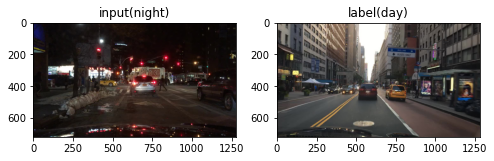

In [48]:
origin_img = Image.open(f'data/밤/795378f0-db2d80b2.jpg')
trans_img = Image.open(f'data/낮/58610009-f3b500dd.jpg')
fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].set_title('input(night)')
ax[0].imshow(origin_img)
ax[1].set_title('label(day)')
ax[1].imshow(trans_img)
plt.show()

In [49]:
cd C:/Users/ChangHwan/Desktop/data/밤

C:\Users\ChangHwan\Desktop\data\밤


In [50]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: D8CF-C1D7

 C:\Users\ChangHwan\Desktop\data\밤 디렉터리

2022-05-19  오후 04:23    <DIR>          .
2022-05-19  오후 04:23    <DIR>          ..
2019-10-21  오후 02:47            40,446 01638325-504ab42d.jpg
2019-10-21  오후 02:47            48,461 01638325-901cd4f5.jpg
2019-10-21  오후 02:47            44,929 01638325-c0f998fd.jpg
2019-10-21  오후 02:47            44,310 01638325-eb95ed3a.jpg
2019-10-21  오후 02:47            31,990 01759047-d88724fe.jpg
2019-10-21  오후 02:47            30,041 02097021-183ed3b9.jpg
2019-10-21  오후 02:47            35,525 02858212-e0d90c01.jpg
2019-10-21  오후 02:47            31,174 02858212-eea55b78.jpg
2019-10-21  오후 02:47            46,702 03009421-80952641.jpg
2019-10-21  오후 02:47            38,235 03118840-e80f61b4.jpg
2019-10-21  오후 02:47            41,549 03343856-ebf78b5f.jpg
2019-10-21  오후 02:47            47,486 03626025-6e619fb2.jpg
2019-10-21  오후 02:47            47,320 03626025-d90d48fc.jpg
2019-10-21  오후 02:47            31,38

In [51]:
cd C:/Users/ChangHwan/Desktop/data/낮

2019-10-21  오후 02:48            28,868 a84aeb29-330e37df.jpg
2019-10-21  오후 02:48            32,249 a84eaeec-490f36bc.jpg
2019-10-21  오후 02:48            41,056 a84eaeec-d8896df8.jpg
2019-10-21  오후 02:48            48,101 a850d055-10de3df5.jpg
2019-10-21  오후 02:48            30,086 a851176a-b6082cd1.jpg
2019-10-21  오후 02:48            34,813 a854f2a3-85f2fe1a.jpg
2019-10-21  오후 02:48            52,088 a8569f15-83f9b25e.jpg
2019-10-21  오후 02:48            52,142 a85a5e95-218e19b3.jpg
2019-10-21  오후 02:48            40,863 a85a5e95-3ceca7a1.jpg
2019-10-21  오후 02:48            31,359 a85b90f5-0618fc18.jpg
2019-10-21  오후 02:48            48,901 a85b90f5-abc13fcc.jpg
2019-10-21  오후 02:48            29,000 a85bacc1-4034abd4.jpg
2019-10-21  오후 02:48            38,195 a85c36c1-c4af57eb.jpg
2019-10-21  오후 02:48            33,355 a85cad42-337048b5.jpg
2019-10-21  오후 02:48            56,170 a8613042-6b300433.jpg
2019-10-21  오후 02:48            39,588 a8613042-e019523a.jpg
2019-10-21  오후 02:48    

In [52]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: D8CF-C1D7

 C:\Users\ChangHwan\Desktop\data\낮 디렉터리

2022-05-19  오후 04:31    <DIR>          .
2022-05-19  오후 04:31    <DIR>          ..
2019-10-21  오후 02:44            73,997 58610009-f3b500dd.jpg
2019-10-21  오후 02:44            30,526 58632273-64be6c00.jpg
2019-10-21  오후 02:44            37,353 58632273-e5cf72b7.jpg
2019-10-21  오후 02:44            55,844 58701498-f031343f.jpg
2019-10-21  오후 02:44            75,117 58863605-132f233f.jpg
2019-10-21  오후 02:44            78,821 58880569-d8d8c8fe.jpg
2019-10-21  오후 02:44            86,594 59000531-12b070a2.jpg
2019-10-21  오후 02:44            89,978 59013048-5868cf40.jpg
2019-10-21  오후 02:44            66,561 59049402-58403b7f.jpg
2019-10-21  오후 02:44            63,348 59229225-6a95445d.jpg
2019-10-21  오후 02:44            67,876 59415542-69a02dac.jpg
2019-10-21  오후 02:44            52,080 59452196-4965d7cb.jpg
2019-10-21  오후 02:44            85,374 59846808-0ec7f426.jpg
2019-10-21  오후 02:44            90,28

In [53]:
cd C:/Users/ChangHwan/Desktop/

C:\Users\ChangHwan\Desktop


# 밤낮 전환 인공지능 데이터 처리

빛번짐과 똑같이 처리함 이유 또한 동일

-1280 * 720 이미지를 512* 384로 축소 


In [54]:
class Dataset(object):
    def __init__(self, label_dir, input_dir, image_size, scale):
        self.label_dir = [os.path.join(label_dir, x) for x in os.listdir(label_dir) if self.check_image_file(x)]
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((128 , 128 ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    
    def data_augmentation(self, hr, lr):

        width, height = hr.size
        
        hr = hr.resize((512, 384), resample=Image.BICUBIC)
        lr = lr.resize((512, 384), resample=Image.BICUBIC)
    
        return hr, lr

    def __getitem__(self, idx):
    
    
        hr = Image.open(self.label_dir[idx]).convert("RGB")
        lr = Image.open(self.input_dir[idx]).convert("RGB") 

        hr, lr = self.data_augmentation(hr, lr) 
        
        return self.to_Tensor(hr), self.to_Tensor(lr) 

    def __len__(self):
        return len(self.label_dir)

In [55]:
class TestDataset(object):
    def __init__(self, input_dir, image_size, scale):
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size , image_size ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
     
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    

    def data_augmentation(self, hr):

        width, height = hr.size

        hr = hr.resize((512, 384), resample=Image.BICUBIC) # 테스트용은 밤 하나이기 때문.

        return hr

    def __getitem__(self, idx):

        hr = Image.open(self.input_dir[idx]).convert("RGB") 

        hr = self.data_augmentation(hr) 
        return self.to_Tensor(hr)

    def __len__(self):
        return len(self.input_dir)

In [56]:
train_dir = 'data/밤/' # 밤
label_dir = 'data/낮/' # 낮
test_dir = 'data/night_test/' #테스트 값.

In [57]:
train_dataset = Dataset(train_dir , label_dir,256,1)
test_dataset = TestDataset(test_dir , 256,1)

In [58]:
pwd

'C:\\Users\\ChangHwan\\Desktop'

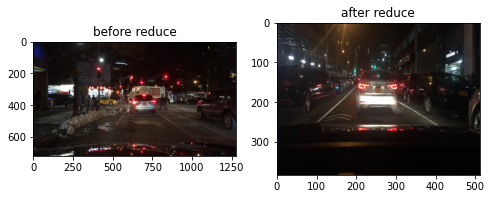

In [59]:
origin_img = Image.open(f'data/밤/795378f0-db2d80b2.jpg')
trans_img = train_dataset[1][0].numpy().transpose(1,2,0)
fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].set_title('before reduce')
ax[0].imshow(origin_img)
ax[1].set_title('after reduce')
ax[1].imshow(trans_img)
plt.show()

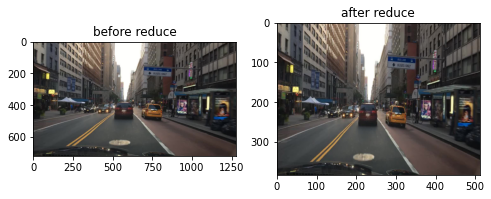

In [60]:
origin_img = Image.open(f'data/낮/58610009-f3b500dd.jpg')
trans_img = train_dataset[0][1].numpy().transpose(1,2,0)
fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].set_title('before reduce')
ax[0].imshow(origin_img)
ax[1].set_title('after reduce')
ax[1].imshow(trans_img)
plt.show()

In [74]:
train_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 2,
    shuffle = True
)

# 밤낮 전환 인공지능 모델 선정

 개발 시 사용할 인공지능 신경망으로는 CNN을 선정
다른 신경망들과 다르게 이미지 데이터를 처리 할 때 이미지의 단순한 특징 뿐만 아니라 패턴까지 알아 낼 수 있는 장점이 있기 때문임

 선정한 모델로는 Cycle Gan임
- 사용할 데이터가 낮,밤에 대해서 같은 장소에 시간이 다른 paire된 데이터가 아니라 아예 개개인의 다른 장소의 낮 , 밤으로 이루어져 있기 때문에 unpaired된 image로 데이터의 특징을 전이할 수 있는 Cycle Gan을 이용한 현재 unpaired된 데이터로 특징을 전이 할 수 있는 모델은 Cycle Gan이 유일함


# generator

In [75]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # reflectionpadding이란 가장자리 기준으로 input값을 패딩영역에 반전하여 복사하여 채우는 기법. 여기선 가장자리 1줄을 채움.
            nn.Conv2d(in_channels, in_channels, 3), #CNN.
            nn.InstanceNorm2d(in_channels), #BatchNorm과 다른 점은 Batch는 전체 Dataset기준으로 Batch를 Normalize하는 것이라면, Instance는 mini-Batch단위로 instance들을 Normalize한다는 점.
            nn.GELU(), # dropout, zoneout, ReLu 함수의 특성을 조합한 것이 GeLU, ReLU가 뛰어나긴 하나 음수가 되어버리면 그 때의 모든 기울기는 0이 되어버리기에 음수에서 조금의 기울기를 주는 형태.
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):  # weight를 통과한 layer들과 통과하지 않은 값들을 더한 residual mapping방식. 
        return x + self.block(x) # x는 통과하지 않은 값들, self.block(x)는 통과한 값들.

In [76]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=3):  # 이 클래스에서 resiudalblock 클래스를 이용할 때 쓰이는 변수. 현재는 layer 9번 쓴다고 선언 되어있고 block수는 맘대로 선언해도 됨.
        super(GeneratorResNet, self).__init__()
        
        out_channels=32   #최초의 convolution 블록. 처음 출력값은 64개.
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), 
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),# in_channels = 3 이유는 이미지는 모두 rgb를 가지고 있기 때문.
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
        )

        channels = out_channels # convolution 후 나온 값을 저장한 모습. 즉, 64가 저장 된다.
                                
                                # 이 작업으로 64개의 출력값을 가지고 있는 은닉층 형성.
        
        self.down = [] #데이터 수를 줄이는게 아니라 우리 빛번짐에서 이미지 축소하고 확장하잖아? 그중 축소하면서 특징 추출하는 과정임.
                       #generator는 기본적으로 Unet model을 기본으로 만들기 때문에 그 중 이미지 축소하면서 특징 추출하는거지
                       
        for _ in range(2): # 2번 반복하는데 index부분이 필요가 없으므로 _ 사용.
            out_channels = channels * 2 #채널 값을 2배로 늘린 후 저장(첫 컨볼루션에서 3-64 여기서 64-128, 그 후 128-256)
            self.down += [                                                  # 이미지 축소 과정.
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels # 각각의 출력값을 저장. 1번째 convolution에선 128. 2번째 convolution에선 256저장.
        self.down = nn.Sequential(*self.down) #위에 for문 과정 down 리스트에 저장.
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]  #residual block을 돌리는 코드.
                                                                                    # for문을 풀자면 ResidualBlock클래스를 9번 돌리고 그 결괏값을 trans에 저장한다는 코드.
                                                                                    
        self.trans = nn.Sequential(*self.trans) #trans라는 리스트에 resudial block 9개층을 저장(여기도 모델에 resudial block을 몇을 주냐에 따라 층 개수 달라짐)
        self.up = [] # residual block을 거쳐서 mapping이 진행된 값을 저장.
        
        for _ in range(2): #upsampling과정. 여기서는 이미지를 축소했기 때문에 다시 복원하는 과정이다.
            out_channels = channels // 2 # 컨볼루션 과정에서 3-64-128-256형태로 축소했기 때문에 다시 256-128-64-3형태로 가야한다.
                                         #여기서는 이미지를 다시 확장하는 과정임
            self.up += [
                nn.Upsample(scale_factor=2), # 이미지가 만약 2*2면 scale_factor = 2면 이미지가 4*4가 됨 이렇게 확장하는과정에서 빈공간의 수를 어떻게 채울지에 따라 3가지 방식 여기선 bil...어쩌고
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1), 
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels #위에 설명 해줬으니까 알겠지? / 다시 64를 저장.
        self.up = nn.Sequential(*self.up) #up list에 이미지 확장해주는 layer를 리스트로 저장
        
        self.out = nn.Sequential( #출력 layer. 이제 64-3 convolution 진행.
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh() #마지막은 Sigmoid나 tanh둘중에 뭐쓸지 고민중 
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

# discriminator

In [77]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False),
            *self.block(64, 128),  
            *self.block(128, 256), 
            *self.block(256, 512),
            
            nn.ZeroPad2d((1,0,1,0)), 
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
        self.scale_factor = 16
        self.m = nn.Sigmoid()
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        x = self.model(x)
        x = self.m(x)
        return x
    

In [183]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [184]:
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.MSELoss()

In [185]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    #G_AB.load_state_dict(torch.load('/content/drive/MyDrive/weight/'+'G_AB2.pt'))
    D_B = D_B.cuda()
    #D_B.load_state_dict(torch.load('/content/drive/MyDrive/weight/'+'D_B2.pt'))
    G_BA = G_BA.cuda()
    #G_BA.load_state_dict(torch.load('/content/drive/MyDrive/weight/'+'G_BA2.pt'))
    D_A = D_A.cuda()
    #D_A.load_state_dict(torch.load('/content/drive/MyDrive/weight/'+'D_A2.pt'))
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


# genrator 결과 시각화

In [90]:
from torchvision.utils import make_grid
import random
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, figside=1.5):
    G_AB.cuda()
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor) #진짜 밤 사진.
    fake_B = G_AB(real_A).detach()
    reconv_A = G_BA(fake_B).detach()
    '''
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
'''
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    reconv_A = make_grid(reconv_A, nrow=nrows, normalize=True)
    #fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, reconv_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

In [91]:
real_A = next(iter(test_loader))
print(real_A.shape)
sample_images(real_A)

torch.Size([2, 3, 384, 512])


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 4.47 GiB already allocated; 0 bytes free; 4.54 GiB reserved in total by PyTorch)

# 밤낮 전환 인공지능 인공지능 모델 학습


Cycle Gan의 모델 구조는 이미지를 축소 -> 이미지 특징 전이 -> 특징이 전이 된 이미지를 확장 하는 순으로 진행이 된다

1번째로는 축소와 확장 횟수에 따른 결과 값을 비교하는 방식으로 진행하고 

2번째로는 특징을 전이할 때 사용하는 신경망 층의 개수에 따른 성능을 비교해서

가장 좋았던 축소 확장 횟수 -> 가장 좋았던 특징 전이 신경망 층 개수 순으로 최종 인공지능 모델 구조를 선정한 후 최종 학습을 진행 할 예정


In [92]:
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.MSELoss()

In [93]:
import itertools
lr = 0.0002


optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr , betas = (0.5,0.999)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr , betas = (0.5,0.999)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr , betas = (0.5,0.999)
)

In [94]:
n_epoches = 300
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [95]:
torch.manual_seed(777)

import gc
from tqdm.notebook import tqdm

for epoch in range(100):
    gc.collect()
    torch.cuda.empty_cache()

    for i, (real_A, real_B) in tqdm(enumerate(train_loader),total = len(train_loader)):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A) 
        fake_A = G_BA(real_B)  
        
        loss_id_A = torch.sqrt(criterion_identity(fake_B, real_A)) 
        loss_id_B = torch.sqrt(criterion_identity(fake_A, real_B))
        loss_identity = (loss_id_A + loss_id_B) / 2

        loss_GAN_AB = criterion_GAN(D_B(fake_B),valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        loss_G = 5.0 *loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        if (epoch+1) % 10 == 0:
            torch.save(G_AB.state_dict(), 'data/weight/'+f'G_AB{epoch+1}.pt') # model.load_state_dict(torch.load(G_AB2.pth))
            torch.save(G_BA.state_dict(), 'data/weight/'+f'G_BA{epoch+1}.pt')
            torch.save(D_A.state_dict(), 'data/weight/'+f'D_A{epoch+1}.pt')
            torch.save(D_B.state_dict(), 'data/weight/'+f'D_B{epoch+1}.pt')
            
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
 
    test_real_A = next(iter(test_loader))
    if (epoch+1) % 5 == 0:
        sample_images(test_real_A)

    loss_D = (loss_D_A + loss_D_B) / 2
    if (epoch+1) % 10 == 0:
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]') 

  0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# 밤낮 인공지능 검증

In [96]:
real_A= next(iter(test_loader))
print(real_A.shape)

sample_images(real_A)

torch.Size([2, 3, 384, 512])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# 전체 결과 보기

In [222]:
model.eval()
G_AB.eval()
model.load_state_dict(torch.load('data/efficientnet.pt'))
G_AB.load_state_dict(torch.load('data/G_AB2.pt'))
with torch.no_grad():
    for image  in test_loader:
        image = image
        output = model(image.to(device))  
        out = G_AB(output.to(device))
        print(image.shape , output.shape ,out.shape)
        break

torch.Size([2, 3, 384, 512]) torch.Size([2, 3, 384, 512]) torch.Size([2, 3, 384, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


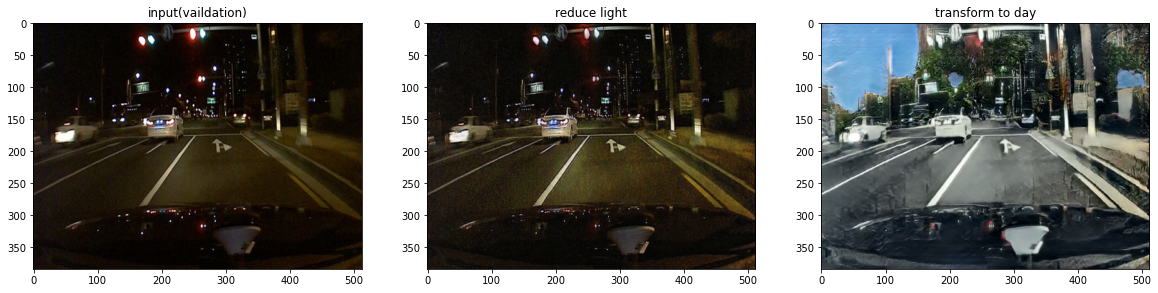

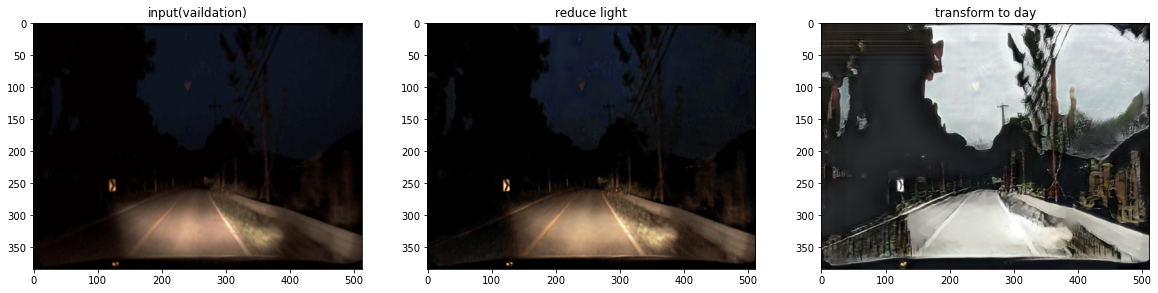

In [223]:
for i in range(2):
    
    fix , ax = plt.subplots(ncols = 3,figsize = (20,15))
    ax[0].set_title('input(vaildation)')
    ax[0].imshow(np.moveaxis(image[i].cpu().numpy(),0,2))
    ax[1].set_title('reduce light')
    ax[1].imshow(np.moveaxis(output[i].cpu().numpy(),0,2))
    ax[2].set_title('transform to day')
    ax[2].imshow(np.moveaxis(out[i].cpu().numpy(),0,2))